# Ensembling results and Predicting with the Test Set

In [29]:
# loading the packages
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.base import BaseEstimator
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from astropy.table import Table
from astropy.io import fits
import h5py
import yaml

import numpy as np
import pandas as pd
import random
import os
import math
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pyarrow.parquet as pq
import tqdm
import logging
# import wandb
import yaml
import sys

from sklearn.preprocessing import StandardScaler, RobustScaler

# Add the repo root to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, repo_root)

from models.model import make_model, TabResnetWrapper, PredictionHead

import matplotlib.ticker as ticker
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

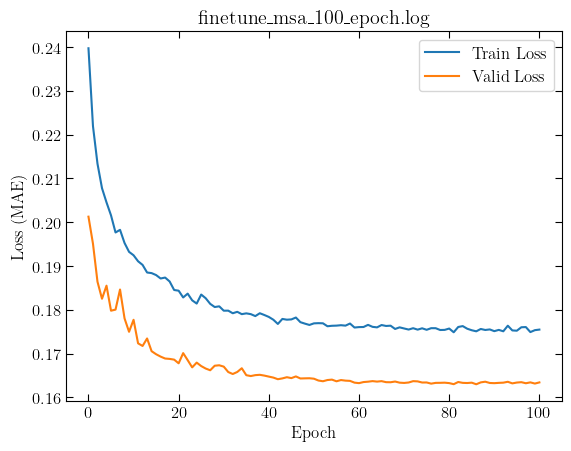

In [7]:
files = glob.glob('../finetune_msa_100_epoch.log')

for file in files:
    with open(file, 'r') as f:
        data = f.readlines()
        val_loss = [float(data[i*2+1].split('Validation Loss: ')[-1].split(', Loss')[0]) for i in range(int(len(data)/2))]
        train_loss = [float(data[i*2].split('Training Loss: ')[-1].split('\n')[0]) for i in range(int(len(data)/2))]
    
        # data
        plt.plot(range(len(train_loss)),train_loss,label='Train Loss')
        plt.plot(range(len(train_loss)),val_loss,label='Valid Loss')
        plt.title(file.split('/')[-1])
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MAE)')
        plt.legend()
        plt.show()

In [39]:
class PredictionHeadCaller(nn.Module):
    def __init__(self, yamldict):
        super().__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        ftlabeldim = int(len(yamldict['data']['classes'])/2 + 1)
        
        if yamldict['finetuning']['activ'] == 'relu':
            ftactivationfunc = nn.ReLU()
        elif yamldict['finetuning']['activ'] == 'elu':
            ftactivationfunc = nn.ELU()
        elif yamldict['finetuning']['activ'] == 'gelu':
            ftactivationfunc = nn.GELU()

        self.ft = PredictionHead(256,ftlabeldim,ftactivationfunc).to(self.device)

    def forward(self, x):
        return self.ft(x)

class Predictor():
    def __init__(self, checkpts, yamldict):
        '''Loading all the ensemble learned models for predicting means'''
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.config = yamldict
        self.heads = []
        self.models = []
        self.xp_masking_ratio = 1.0
        self.m_masking_ratio = 0.0
    
        # Load each prediction head
        for path in checkpts:
            model, head = self._load_head(path)
            self.models.append(model)
            self.heads.append(head)

    def _load_head(self, path):
        # call models
        blocks_dims = self.config['model']['layer_dims']
        pt_activ = self.config['model']['pt_activ_func']
        d_embed = self.config['model']['rtdl_embed']
        norm = self.config['model']['norm']

        cols = self.config['data']['feature_cols']
        recon_cols = self.config['data']['recon_cols']
    
        model = make_model(
            len(cols),
            blocks_dims,
            len(recon_cols),
            pt_activ,
            d_embed,
            norm,
        )
        head = PredictionHeadCaller(self.config)
        # load state dict
        state_dict = torch.load(path, map_location=self.device)
        # assign to models
        model.load_state_dict(state_dict['autoencoder_state_dict'])
        renamed_state_dict = {f"ft.{k}": v for k, v in state_dict['prediction_head_state_dict'].items()}
        head.load_state_dict(renamed_state_dict)
        # head.load_state_dict(state_dict['prediction_head_state_dict'])
        # set to eval
        model.eval()
        head.eval() # might need a .to(self.device)
        return model.to(self.device), head.to(self.device)

    def _apply_mask(self, X, col_start_fixed=5, col_end_fixed=115, col_start_random=115):
        """
        Apply two masking strategies to the input tensor while also tracking NaN locations:
        1. Mask a fixed subsection of columns (X[:, 5:115]) for a subset of rows.
        2. Randomly mask columns starting from X[:, 115:] for all rows.
        
        Args:
            X (Tensor): Input data tensor.
            col_start_fixed (int): Starting index of the fixed subsection of columns to mask.
            col_end_fixed (int): Ending index (exclusive) of the fixed subsection to mask.
            col_start_random (int): Starting index for columns to apply random masking.
        
        Returns:
            X_masked (Tensor): Tensor with both masking strategies applied.
            mask (Tensor): Boolean mask indicating where the mask was applied.
            nan_mask (Tensor): Boolean mask indicating where the input originally had NaNs.
        """
        X_masked = X.clone().detach().to(self.device)
    
        # Track NaN locations
        nan_mask = ~torch.isnan(X_masked)

        X_masked[~nan_mask] = -9999
    
        # 1. Apply fixed subsection column masking (X[:, 5:115]) for a portion of rows
        num_rows_to_mask = int(self.xp_masking_ratio * X.shape[0])
        row_indices = torch.randperm(X.shape[0])[:num_rows_to_mask].to(self.device)
    
        # Create a mask for the fixed subsection of columns
        mask_fixed = torch.zeros(X.shape, dtype=torch.bool).to(self.device)
        mask_fixed[row_indices, col_start_fixed:col_end_fixed] = True
    
        # Apply fixed column subsection mask to selected rows
        X_masked[mask_fixed] = -9999  
    
        # 2. Apply random masking for columns starting from col_start_random (X[:, 115:])
        mask_random = torch.rand(X[:, col_start_random:].shape).to(self.device) < self.m_masking_ratio
        X_masked[:, col_start_random:][mask_random] = -9999  
    
        # 3. Combine both masks
        combined_mask = torch.zeros_like(X, dtype=torch.bool).to(self.device)
        combined_mask[:, col_start_random:] = mask_random
        combined_mask[row_indices, col_start_fixed:col_end_fixed] = True
    
        return X_masked, combined_mask, nan_mask

    def ensemble_predict(self, X):
        '''predict mean from all models'''
        
        X_test = torch.Tensor(X).to(self.device)
        
        with torch.no_grad():  # Disable gradient computation for inference
            # masking
            masked_X, _, nanmask = self._apply_mask(X_test)    
            nan_mask = ~torch.isnan(X_test)
            X_test[~nan_mask] = -9999

            predictions = []
            masked_predictions = []
            for model, head in zip(self.models,self.heads):
                # forward pass
                test_encoded = model.encoder(X_test)
                masked_test_encoded = model.encoder(masked_X)

                pred = head(test_encoded)
                m_pred = head(masked_test_encoded)
                predictions.append(pred.cpu())
                masked_predictions.append(m_pred.cpu())

            # if (self.yamldict['loss_fn'] == 'gnll') or (self.yamldict['loss_fn'] == 'wgnll'):
            #     y_pred_err = predictions[:, int(ftlabeldim/2):]
            #     predictions = predictions[:, :int(ftlabeldim/2)]
    
            #     masked_y_pred_err = masked_predictions[:, int(ftlabeldim/2):]
            #     masked_predictions = masked_predictions[:, :int(ftlabeldim/2)]
                
            return torch.stack(predictions), torch.stack(masked_predictions)
            # return torch.stack(predictions).mean(dim=0), torch.stack(masked_predictions).mean(dim=0)

In [43]:
checkpoints = glob.glob('../masked_stellar_autoencoder_ft_10M.pth')

with open('../configs/finetune.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [44]:
predictor = Predictor(checkpoints, config)

In [45]:
data = Table.read(config['data']['ft_datafile']).to_pandas()
    
errordata = data.copy()

cols = config['data']['feature_cols']
classes = config['data']['classes']
error_cols = config['data']['error_cols']

data = data[classes+cols]
errordata = errordata[error_cols]
errordata = errordata.fillna(errordata.max())

trainset, validset, etrainset, evalidset = train_test_split(data.to_numpy(), errordata.to_numpy(), test_size=0.2, random_state=42)
validset, testset, evalidset, etestset = train_test_split(validset, evalidset, test_size=0.33, random_state=42)

# assuming that the layout of the file is label, label error, ..., features
num_classes = len(classes)

target_train = trainset[:, :num_classes]
trainset = trainset[:, num_classes:]
target_test = testset[:, :num_classes]
testset = testset[:, num_classes:]

# scaling the targets (individually in case of single task finetuning) and features
scalers = [StandardScaler() for _ in range(int(num_classes/2))]
labelled_set = []

for i in range(int(num_classes/2)):
    labelled_set.append(scalers[i].fit_transform(target_train[:, i*2].reshape(-1, 1)))
    
target_set = target_test[:, [i for i in range(num_classes) if i % 2 == 0]]

pos = cols.index("PARALLAX")

scaler = StandardScaler()
label = scaler.fit_transform(trainset[:, pos].reshape(-1, 1))

labelled_set.append(label)
labelled_set = np.concatenate(labelled_set, axis=1)

scalers.append(scaler)

target_set = np.concatenate([target_set, testset[:, pos].reshape(-1, 1)], axis=1)

labels = [i for i in range(num_classes) if i % 2 == 0] + ['parallax']

featurescaler = RobustScaler()
featurescaler.fit(trainset)

testset = featurescaler.transform(testset)
scale_factors = featurescaler.scale_
etestset = etestset / scale_factors

In [46]:
preds, m_preds = predictor.ensemble_predict(testset)

In [48]:
preds = preds.mean(dim=0)
m_preds = m_preds.mean(dim=0)

In [50]:
e_lower_preds = preds[:, :, 0]
e_upper_preds = preds[:, :, 2]
preds = preds[:, :, 1]
m_e_lower_preds = m_preds[:, :, 0]
m_e_upper_preds = m_preds[:, :, 2]
m_preds = m_preds[:, :, 1]

In [51]:
pred_teffs = scalers[0].inverse_transform(preds[:, 0].reshape(-1, 1)).flatten()
e_lower_teffs = scalers[0].inverse_transform(e_lower_preds[:, 0].reshape(-1, 1)).flatten()
e_upper_teffs = scalers[0].inverse_transform(e_upper_preds[:, 0].reshape(-1, 1)).flatten()
pred_loggs = scalers[1].inverse_transform(preds[:, 1].reshape(-1, 1)).flatten()
e_lower_loggs = scalers[1].inverse_transform(e_lower_preds[:, 1].reshape(-1, 1)).flatten()
e_upper_loggs = scalers[1].inverse_transform(e_upper_preds[:, 1].reshape(-1, 1)).flatten()
pred_fehs = scalers[2].inverse_transform(preds[:, 2].reshape(-1, 1)).flatten()
e_lower_fehs = scalers[2].inverse_transform(e_lower_preds[:, 2].reshape(-1, 1)).flatten()
e_upper_fehs = scalers[2].inverse_transform(e_upper_preds[:, 2].reshape(-1, 1)).flatten()
pred_afes = scalers[3].inverse_transform(preds[:, 3].reshape(-1, 1)).flatten()
e_lower_afes = scalers[3].inverse_transform(e_lower_preds[:, 3].reshape(-1, 1)).flatten()
e_upper_afes = scalers[3].inverse_transform(e_upper_preds[:, 3].reshape(-1, 1)).flatten()
pred_ages = scalers[4].inverse_transform(preds[:, 4].reshape(-1, 1)).flatten()
e_lower_ages = scalers[4].inverse_transform(e_lower_preds[:, 4].reshape(-1, 1)).flatten()
e_upper_ages = scalers[4].inverse_transform(e_upper_preds[:, 4].reshape(-1, 1)).flatten()
pred_parallax = scalers[5].inverse_transform(preds[:, 5].reshape(-1, 1)).flatten()
e_lower_parallaxs = scalers[5].inverse_transform(e_lower_preds[:, 5].reshape(-1, 1)).flatten()
e_upper_parallaxs = scalers[5].inverse_transform(e_upper_preds[:, 5].reshape(-1, 1)).flatten()

m_pred_teffs = scalers[0].inverse_transform(m_preds[:, 0].reshape(-1, 1)).flatten()
m_e_lower_teffs = scalers[0].inverse_transform(m_e_lower_preds[:, 0].reshape(-1, 1)).flatten()
m_e_upper_teffs = scalers[0].inverse_transform(m_e_upper_preds[:, 0].reshape(-1, 1)).flatten()
m_pred_loggs = scalers[1].inverse_transform(m_preds[:, 1].reshape(-1, 1)).flatten()
m_e_lower_loggs = scalers[1].inverse_transform(m_e_lower_preds[:, 1].reshape(-1, 1)).flatten()
m_e_upper_loggs = scalers[1].inverse_transform(m_e_upper_preds[:, 1].reshape(-1, 1)).flatten()
m_pred_fehs = scalers[2].inverse_transform(m_preds[:, 2].reshape(-1, 1)).flatten()
m_e_lower_fehs = scalers[2].inverse_transform(m_e_lower_preds[:, 2].reshape(-1, 1)).flatten()
m_e_upper_fehs = scalers[2].inverse_transform(m_e_upper_preds[:, 2].reshape(-1, 1)).flatten()
m_pred_afes = scalers[3].inverse_transform(m_preds[:, 3].reshape(-1, 1)).flatten()
m_e_lower_afes = scalers[3].inverse_transform(m_e_lower_preds[:, 3].reshape(-1, 1)).flatten()
m_e_upper_afes = scalers[3].inverse_transform(m_e_upper_preds[:, 3].reshape(-1, 1)).flatten()
m_pred_ages = scalers[4].inverse_transform(m_preds[:, 4].reshape(-1, 1)).flatten()
m_e_lower_ages = scalers[4].inverse_transform(m_e_lower_preds[:, 4].reshape(-1, 1)).flatten()
m_e_upper_ages = scalers[4].inverse_transform(m_e_upper_preds[:, 4].reshape(-1, 1)).flatten()
m_pred_parallax = scalers[5].inverse_transform(m_preds[:, 5].reshape(-1, 1)).flatten()
m_e_lower_parallaxs = scalers[5].inverse_transform(m_e_lower_preds[:, 5].reshape(-1, 1)).flatten()
m_e_upper_parallaxs = scalers[5].inverse_transform(m_e_upper_preds[:, 5].reshape(-1, 1)).flatten()

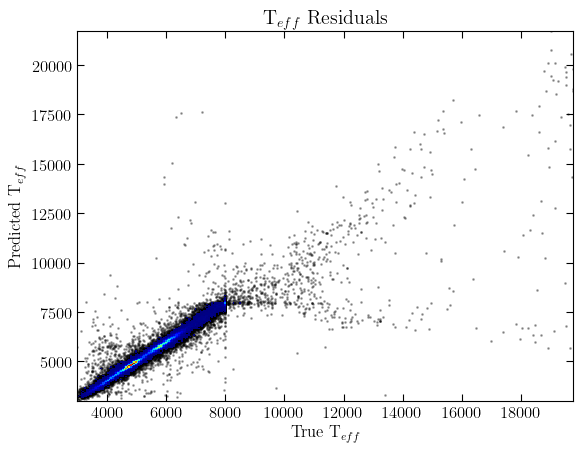

In [52]:
plt.scatter(target_set[:, 0],pred_teffs,s=1,c='k',alpha=0.3)
plt.hist2d(target_set[:, 0],pred_teffs,bins=(300,300),cmin=5,cmap='jet');

plt.title(r'T$_{eff}$ Residuals')
plt.xlabel(r'True T$_{eff}$')
plt.ylabel(r'Predicted T$_{eff}$');
# plt.xlim(2500,9500)

Total RMSE: 339.9699128504819
Total MAE: 101.70493435524212
R2: 0.9042932831935001


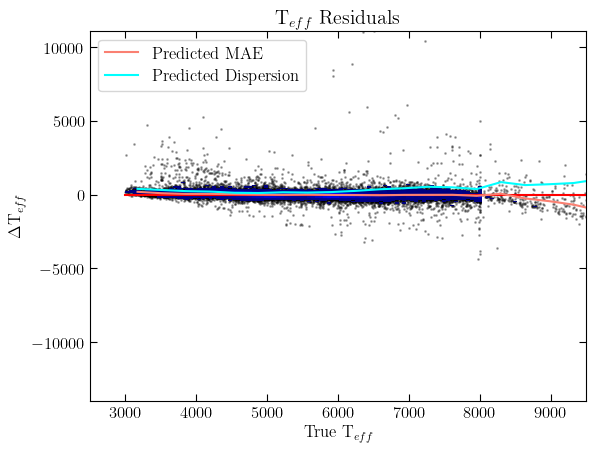

In [53]:
plt.scatter(target_set[:, 0],pred_teffs-target_set[:, 0],s=1,c='k',alpha=0.3)
plt.hist2d(target_set[:, 0],pred_teffs-target_set[:, 0],bins=(300,300),cmin=5,cmap='jet');

plt.title(r'T$_{eff}$ Residuals')
plt.xlabel(r'True T$_{eff}$')
plt.ylabel(r'$\Delta$T$_{eff}$');

targs = target_set[:, 0]
outs = pred_teffs

r2 = r2_score(targs, outs)
rmse = np.sqrt(mean_squared_error(targs, outs))
mae = mean_absolute_error(targs, outs)

plt.plot([min(targs),max(targs)],[0,0],'r')
values = outs-targs
bin_edges = np.linspace(min(targs),max(targs),50)
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_indices = np.digitize(targs, bin_edges)
bin_means = []
bin_stds = []
for j in range(1, len(bin_edges)):
    bin_values = values[bin_indices == j]
    if len(bin_values) > 0:
        bin_mean = bin_values.mean()
        bin_std = bin_values.std()
    else:
        bin_mean = np.nan
        bin_std = np.nan
    bin_stds.append(bin_std)
    bin_means.append(bin_mean)
    
plt.plot(bin_mids, bin_means, color='salmon', linestyle='-', label='Predicted MAE')
plt.plot(bin_mids, bin_stds, color='cyan', linestyle='-', label='Predicted Dispersion')
plt.xlim(2500,9500)
plt.legend(fancybox=True)

print('Total RMSE:',rmse)
print('Total MAE:',mae)
print('R2:',r2)

Total RMSE: 0.18906541832407223
Total MAE: 0.11423635157664642
R2: 0.9702176339086257


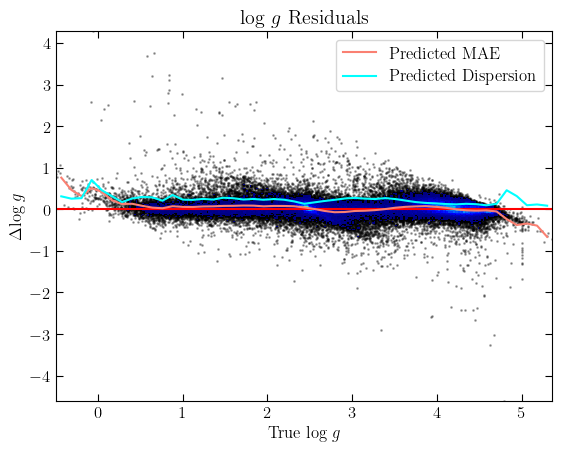

In [54]:
plt.scatter(target_set[:, 1],pred_loggs-target_set[:, 1],s=1,c='k',alpha=0.3)
plt.hist2d(target_set[:, 1],pred_loggs-target_set[:, 1],bins=(300,300),cmin=5,cmap='jet');

plt.title(r'log $g$ Residuals')
plt.xlabel(r'True log $g$')
plt.ylabel(r'$\Delta$log $g$');

targs = target_set[:, 1]
outs = pred_loggs

r2 = r2_score(targs, outs)
rmse = np.sqrt(mean_squared_error(targs, outs))
mae = mean_absolute_error(targs, outs)

plt.plot([min(targs),max(targs)],[0,0],'r')
values = outs-targs
bin_edges = np.linspace(min(targs),max(targs),50)
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_indices = np.digitize(targs, bin_edges)
bin_means = []
bin_stds = []
for j in range(1, len(bin_edges)):
    bin_values = values[bin_indices == j]
    if len(bin_values) > 0:
        bin_mean = bin_values.mean()
        bin_std = bin_values.std()
    else:
        bin_mean = np.nan
        bin_std = np.nan
    bin_stds.append(bin_std)
    bin_means.append(bin_mean)
    
plt.plot(bin_mids, bin_means, color='salmon', linestyle='-', label='Predicted MAE')
plt.plot(bin_mids, bin_stds, color='cyan', linestyle='-', label='Predicted Dispersion')

plt.legend(fancybox=True)

print('Total RMSE:',rmse)
print('Total MAE:',mae)
print('R2:',r2)

Total RMSE: 0.17070597080445854
Total MAE: 0.09408781297463323
R2: 0.796926045663034


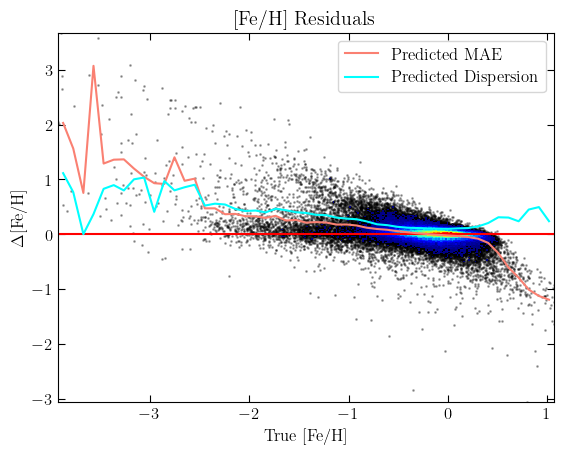

In [55]:
mask = ~np.isnan(target_set[:, 2])

plt.scatter(target_set[:, 2][mask],pred_fehs[mask]-target_set[:, 2][mask],s=1,c='k',alpha=0.3)
plt.hist2d(target_set[:, 2][mask],pred_fehs[mask]-target_set[:, 2][mask],bins=(300,300),cmin=5,cmap='jet');

plt.title(r'[Fe/H] Residuals')
plt.xlabel(r'True [Fe/H]')
plt.ylabel(r'$\Delta$[Fe/H]');

mask = ~np.isnan(target_set[:, 2])
targs = target_set[:, 2][mask]
outs = pred_fehs[mask]

r2 = r2_score(targs, outs)
rmse = np.sqrt(mean_squared_error(targs, outs))
mae = mean_absolute_error(targs, outs)

plt.plot([min(targs),max(targs)],[0,0],'r')
values = outs-targs
bin_edges = np.linspace(min(targs),max(targs),50)
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_indices = np.digitize(targs, bin_edges)
bin_means = []
bin_stds = []
for j in range(1, len(bin_edges)):
    bin_values = values[bin_indices == j]
    if len(bin_values) > 0:
        bin_mean = bin_values.mean()
        bin_std = bin_values.std()
    else:
        bin_mean = np.nan
        bin_std = np.nan
    bin_stds.append(bin_std)
    bin_means.append(bin_mean)
    
plt.plot(bin_mids, bin_means, color='salmon', linestyle='-', label='Predicted MAE')
plt.plot(bin_mids, bin_stds, color='cyan', linestyle='-', label='Predicted Dispersion')

plt.legend(fancybox=True)

print('Total RMSE:',rmse)
print('Total MAE:',mae)
print('R2:',r2)

Total RMSE: 0.07249409106785847
Total MAE: 0.04652343292609156
R2: 0.6125947112994948


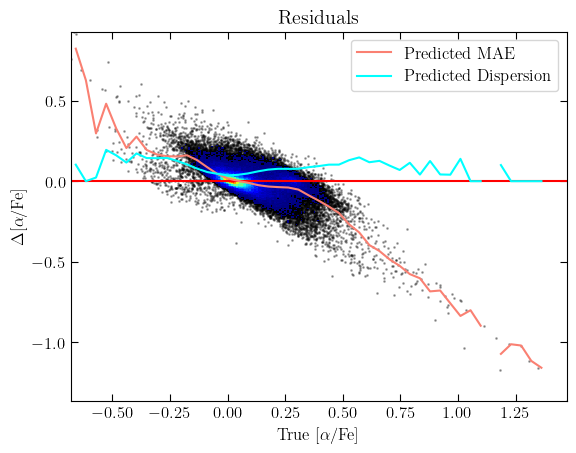

In [56]:
mask = ~np.isnan(target_set[:, 3])

plt.scatter(target_set[:, 3][mask],pred_afes[mask]-target_set[:, 3][mask],s=1,c='k',alpha=0.3)
plt.hist2d(target_set[:, 3][mask],pred_afes[mask]-target_set[:, 3][mask],bins=(300,300),cmin=5,cmap='jet');

plt.title(r' Residuals')
plt.xlabel(r'True [$\alpha$/Fe]')
plt.ylabel(r'$\Delta$[$\alpha$/Fe]');

mask = ~np.isnan(target_set[:, 3])
targs = target_set[:, 3][mask]
outs = pred_afes[mask]

r2 = r2_score(targs, outs)
rmse = np.sqrt(mean_squared_error(targs, outs))
mae = mean_absolute_error(targs, outs)

plt.plot([min(targs),max(targs)],[0,0],'r')
values = outs-targs
bin_edges = np.linspace(min(targs),max(targs),50)
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_indices = np.digitize(targs, bin_edges)
bin_means = []
bin_stds = []
for j in range(1, len(bin_edges)):
    bin_values = values[bin_indices == j]
    if len(bin_values) > 0:
        bin_mean = bin_values.mean()
        bin_std = bin_values.std()
    else:
        bin_mean = np.nan
        bin_std = np.nan
    bin_stds.append(bin_std)
    bin_means.append(bin_mean)
    
plt.plot(bin_mids, bin_means, color='salmon', linestyle='-', label='Predicted MAE')
plt.plot(bin_mids, bin_stds, color='cyan', linestyle='-', label='Predicted Dispersion')

plt.legend(fancybox=True)

print('Total RMSE:',rmse)
print('Total MAE:',mae)
print('R2:',r2)

Total RMSE: 2.1518173200901716
Total MAE: 1.4755840927270134
R2: 0.5815193517920318


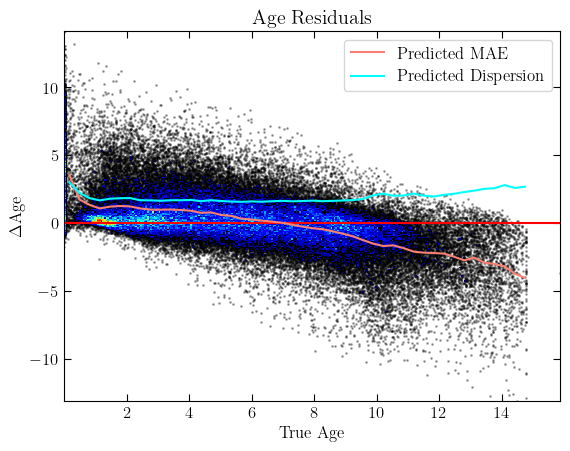

In [57]:
mask = ~np.isnan(target_set[:, 4])

plt.scatter(target_set[:, 4][mask],pred_ages[mask]-target_set[:, 4][mask],s=1,c='k',alpha=0.3)
plt.hist2d(target_set[:, 4][mask],pred_ages[mask]-target_set[:, 4][mask],bins=(300,300),cmin=5,cmap='jet');

plt.title(r'Age Residuals')
plt.xlabel(r'True Age')
plt.ylabel(r'$\Delta$Age');

mask = ~np.isnan(target_set[:, 4])
targs = target_set[:, 4][mask]
outs = pred_ages[mask]

r2 = r2_score(targs, outs)
rmse = np.sqrt(mean_squared_error(targs, outs))
mae = mean_absolute_error(targs, outs)

plt.plot([min(targs),max(targs)],[0,0],'r')
values = outs-targs
bin_edges = np.linspace(min(targs),max(targs),50)
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_indices = np.digitize(targs, bin_edges)
bin_means = []
bin_stds = []
for j in range(1, len(bin_edges)):
    bin_values = values[bin_indices == j]
    if len(bin_values) > 0:
        bin_mean = bin_values.mean()
        bin_std = bin_values.std()
    else:
        bin_mean = np.nan
        bin_std = np.nan
    bin_stds.append(bin_std)
    bin_means.append(bin_mean)
    
plt.plot(bin_mids, bin_means, color='salmon', linestyle='-', label='Predicted MAE')
plt.plot(bin_mids, bin_stds, color='cyan', linestyle='-', label='Predicted Dispersion')

plt.legend(fancybox=True)

print('Total RMSE:',rmse)
print('Total MAE:',mae)
print('R2:',r2)

Total RMSE: 0.13956126211968167
Total MAE: 0.08232888255183983
R2: 0.9159901809448571


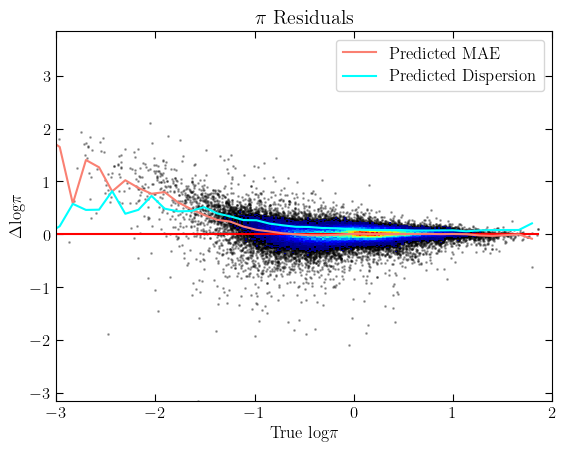

In [58]:
mask = ~np.isnan(target_set[:, 5]) & (target_set[:, 5] > 0) & (pred_parallax > 0)

plt.scatter(np.log10(target_set[:, 5][mask]),np.log10(pred_parallax[mask])-np.log10(target_set[:, 5][mask]),s=1,c='k',alpha=0.3)
plt.hist2d(np.log10(target_set[:, 5][mask]),np.log10(pred_parallax[mask])-np.log10(target_set[:, 5][mask]),bins=(300,300),cmin=5,cmap='jet');

plt.title(r'$\pi$ Residuals')
plt.xlabel(r'True log$\pi$')
plt.ylabel(r'$\Delta$log$\pi$');
plt.xlim(-3,2)

# mask = ~np.isnan(target_set[:, 5])
targs = np.log10(target_set[:, 5][mask])
outs = np.log10(pred_parallax[mask])

r2 = r2_score(targs, outs)
rmse = np.sqrt(mean_squared_error(targs, outs))
mae = mean_absolute_error(targs, outs)

plt.plot([min(targs),max(targs)],[0,0],'r')
values = outs-targs
bin_edges = np.linspace(min(targs),max(targs),50)
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_indices = np.digitize(targs, bin_edges)
bin_means = []
bin_stds = []
for j in range(1, len(bin_edges)):
    bin_values = values[bin_indices == j]
    if len(bin_values) > 0:
        bin_mean = bin_values.mean()
        bin_std = bin_values.std()
    else:
        bin_mean = np.nan
        bin_std = np.nan
    bin_stds.append(bin_std)
    bin_means.append(bin_mean)
    
plt.plot(bin_mids, bin_means, color='salmon', linestyle='-', label='Predicted MAE')
plt.plot(bin_mids, bin_stds, color='cyan', linestyle='-', label='Predicted Dispersion')

plt.legend(fancybox=True)

print('Total RMSE:',rmse)
print('Total MAE:',mae)
print('R2:',r2)

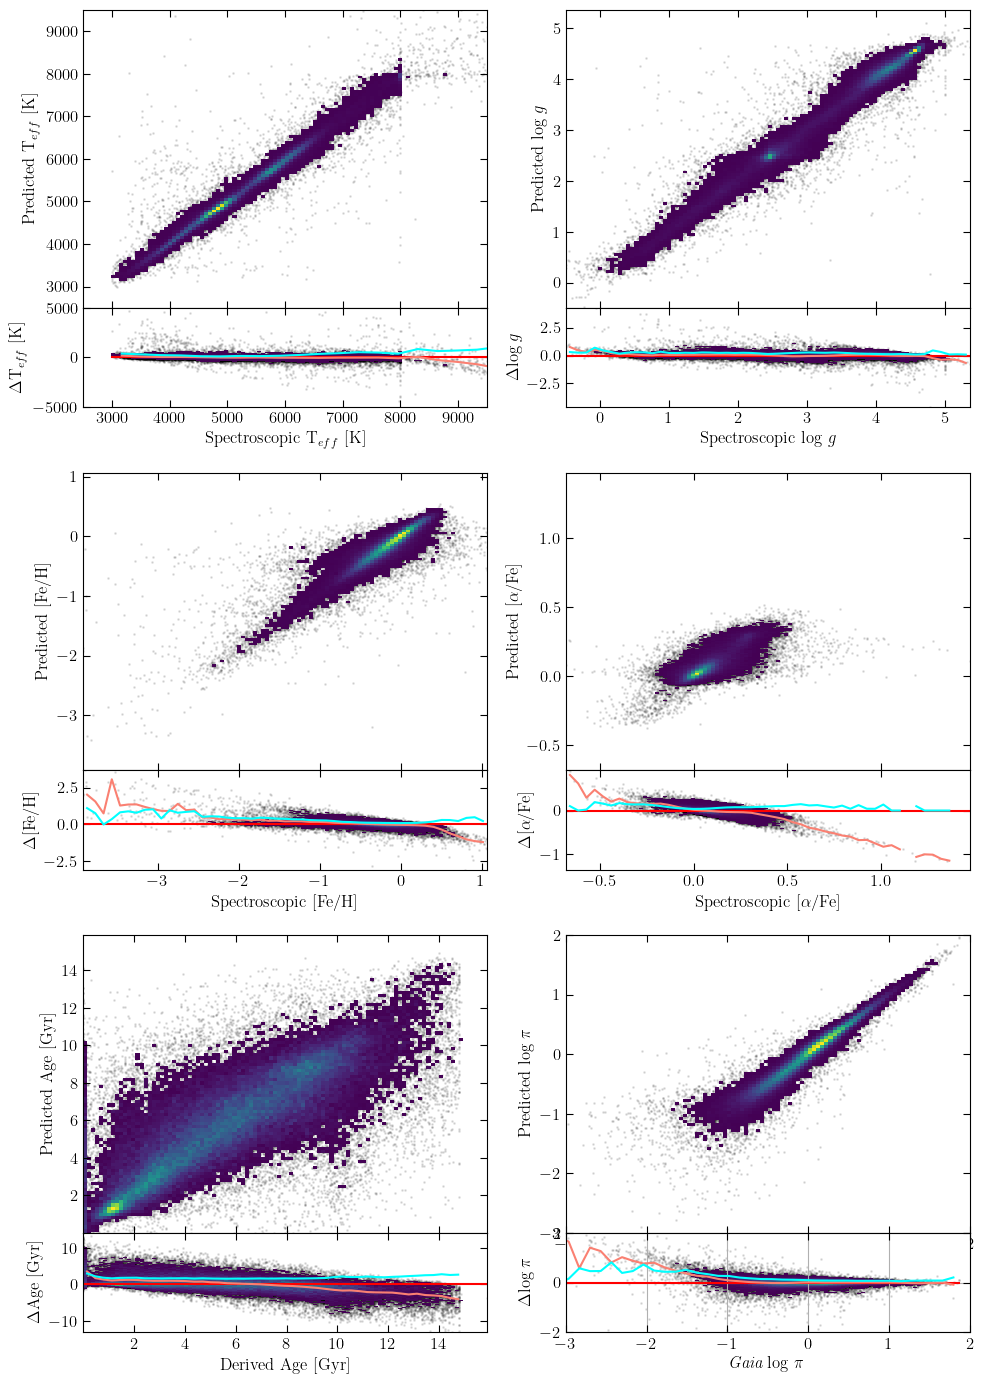

In [59]:
# fig, ax = plt.subplots(
#     nrows=6, ncols=2, 
#     figsize=(8, 10), 
#     gridspec_kw={'height_ratios': [3, 1, 3, 1, 3, 1]}
# )

fig = plt.figure(figsize=(10, 14))

outer = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

ax_list = []

for i in range(3):
    for j in range(2):  # left and right column
        # Inner GridSpec: 2 rows per group (pred + resid), no space between them
        inner = gridspec.GridSpecFromSubplotSpec(
            2, 1, subplot_spec=outer[i, j], height_ratios=[3, 1], hspace=0.0
        )
        ax_pred = fig.add_subplot(inner[0])
        ax_resid = fig.add_subplot(inner[1], sharex=ax_pred)
    
        ax_list.append(ax_pred)
        ax_list.append(ax_resid)

ax = np.array([[ax_list[0],ax_list[2]],
               [ax_list[1],ax_list[3]],
               [ax_list[4],ax_list[6]],
               [ax_list[5],ax_list[7]],
               [ax_list[8],ax_list[10]],
               [ax_list[9],ax_list[11]]])

mask = ~np.isnan(target_set[:, 0])
ax[0,0].scatter(target_set[:, 0][mask],pred_teffs[mask],s=1,c='k',alpha=0.1)
h = ax[0,0].hist2d(target_set[:, 0][mask],pred_teffs[mask],bins=(100,100),cmin=5,cmap='viridis',range=[[2500,9500],[2500,9500]]);
ax[0,0].set_ylabel(r'Predicted T$_{eff}$ [K]')

ax[0,0].set_xlim(2500,9500)
ax[0,0].set_ylim(2500,9500)

ax[1,0].scatter(target_set[:, 0][mask],pred_teffs[mask]-target_set[:, 0][mask],s=1,c='k',alpha=0.1)
ax[1,0].hist2d(target_set[:, 0][mask],pred_teffs[mask]-target_set[:, 0][mask],bins=(100,100),cmin=5,cmap='viridis',range=[[2500,9500],[-5000,5000]]);

ax[1,0].set_xlabel(r'Spectroscopic T$_{eff}$ [K]')
ax[1,0].set_xlim(2500,9500)
# plt.ylabel(r'Predicted T$_{eff}$');
ax[1,0].set_ylabel(r'$\Delta$T$_{eff}$ [K]');

targs = target_set[:, 0][mask]
outs = pred_teffs[mask]

r2 = r2_score(targs, outs)
rmse = np.sqrt(mean_squared_error(targs, outs))
mae = mean_absolute_error(targs, outs)

ax[1,0].plot([min(targs),max(targs)],[0,0],'r')
values = outs-targs
bin_edges = np.linspace(min(targs),max(targs),50)
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_indices = np.digitize(targs, bin_edges)
bin_means = []
bin_stds = []
for j in range(1, len(bin_edges)):
    bin_values = values[bin_indices == j]
    if len(bin_values) > 0:
        bin_mean = bin_values.mean()
        bin_std = bin_values.std()
    else:
        bin_mean = np.nan
        bin_std = np.nan
    bin_stds.append(bin_std)
    bin_means.append(bin_mean)
    
ax[1,0].plot(bin_mids, bin_means, color='salmon', linestyle='-', label='MAE')
ax[1,0].plot(bin_mids, bin_stds, color='cyan', linestyle='-', label='Dispersion')
# cbar = plt.colorbar(h[3], ax=[ax[0,0], ax[1,0]])
# cbar.set_label(r'$N_{stars}$')
# ax[1,0].legend(fancybox=True)

mask = ~np.isnan(target_set[:, 1])
ax[0,1].scatter(target_set[:, 1][mask],pred_loggs[mask],s=1,c='k',alpha=0.1)
h = ax[0,1].hist2d(target_set[:, 1][mask],pred_loggs[mask],bins=(100,100),cmin=5,cmap='viridis');

ax[0,1].set_xlim(min(target_set[:, 1][mask]), max(target_set[:, 1][mask]))
ax[0,1].set_ylim(min(target_set[:, 1][mask]), max(target_set[:, 1][mask]))

ax[0,1].set_ylabel(r'Predicted log $g$')

ax[1,1].scatter(target_set[:, 1][mask],pred_loggs[mask]-target_set[:, 1][mask],s=1,c='k',alpha=0.1)
ax[1,1].hist2d(target_set[:, 1][mask],pred_loggs[mask]-target_set[:, 1][mask],bins=(100,100),cmin=5,cmap='viridis');

ax[1,1].set_xlabel(r'Spectroscopic log $g$')
# plt.ylabel(r'Predicted T$_{eff}$');
ax[1,1].set_ylabel(r'$\Delta$log $g$');

targs = target_set[:, 1][mask]
outs = pred_loggs[mask]

r2 = r2_score(targs, outs)
rmse = np.sqrt(mean_squared_error(targs, outs))
mae = mean_absolute_error(targs, outs)

ax[1,1].plot([min(targs),max(targs)],[0,0],'r')
values = outs-targs
bin_edges = np.linspace(min(targs),max(targs),50)
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_indices = np.digitize(targs, bin_edges)
bin_means = []
bin_stds = []
for j in range(1, len(bin_edges)):
    bin_values = values[bin_indices == j]
    if len(bin_values) > 0:
        bin_mean = bin_values.mean()
        bin_std = bin_values.std()
    else:
        bin_mean = np.nan
        bin_std = np.nan
    bin_stds.append(bin_std)
    bin_means.append(bin_mean)
    
ax[1,1].plot(bin_mids, bin_means, color='salmon', linestyle='-', label='MAE (Total = '+str(round(mae,2))+')')
ax[1,1].plot(bin_mids, bin_stds, color='cyan', linestyle='-', label='Dispersion (Total = '+str(round(rmse,2))+')')
# cbar = plt.colorbar(h[3], ax=[ax[0,1], ax[1,1]])
# cbar.set_label(r'$N_{stars}$')
# ax[1,1].legend(fancybox=True)

mask = ~np.isnan(target_set[:, 2])
ax[2,0].scatter(target_set[:, 2][mask],pred_fehs[mask],s=1,c='k',alpha=0.1)
h = ax[2,0].hist2d(target_set[:, 2][mask],pred_fehs[mask],bins=(100,100),cmin=5,cmap='viridis');

ax[2,0].set_xlim(min(target_set[:, 2][mask]), max(target_set[:, 2][mask]))
ax[2,0].set_ylim(min(target_set[:, 2][mask]), max(target_set[:, 2][mask]))

ax[2,0].set_ylabel(r'Predicted [Fe/H]')

ax[3,0].scatter(target_set[:, 2][mask],pred_fehs[mask]-target_set[:, 2][mask],s=1,c='k',alpha=0.1)
ax[3,0].hist2d(target_set[:, 2][mask],pred_fehs[mask]-target_set[:, 2][mask],bins=(100,100),cmin=5,cmap='viridis');

ax[3,0].set_xlabel(r'Spectroscopic [Fe/H]')
# plt.ylabel(r'Predicted T$_{eff}$');
ax[3,0].set_ylabel(r'$\Delta$[Fe/H]');

targs = target_set[:, 2][mask]
outs = pred_fehs[mask]

r2 = r2_score(targs, outs)
rmse = np.sqrt(mean_squared_error(targs, outs))
mae = mean_absolute_error(targs, outs)

ax[3,0].plot([min(targs),max(targs)],[0,0],'r')
values = outs-targs
bin_edges = np.linspace(min(targs),max(targs),50)
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_indices = np.digitize(targs, bin_edges)
bin_means = []
bin_stds = []
for j in range(1, len(bin_edges)):
    bin_values = values[bin_indices == j]
    if len(bin_values) > 0:
        bin_mean = bin_values.mean()
        bin_std = bin_values.std()
    else:
        bin_mean = np.nan
        bin_std = np.nan
    bin_stds.append(bin_std)
    bin_means.append(bin_mean)
    
ax[3,0].plot(bin_mids, bin_means, color='salmon', linestyle='-', label='MAE (Total = '+str(round(mae,2))+')')
ax[3,0].plot(bin_mids, bin_stds, color='cyan', linestyle='-', label='Dispersion (Total = '+str(round(rmse,2))+')')
# cbar = plt.colorbar(h[3], ax=[ax[2,0], ax[3,0]])
# cbar.set_label(r'$N_{stars}$')
# ax[1,0].legend(fancybox=True)

mask = ~np.isnan(target_set[:, 3])
ax[2,1].scatter(target_set[:, 3][mask],pred_afes[mask],s=1,c='k',alpha=0.1)
h = ax[2,1].hist2d(target_set[:, 3][mask],pred_afes[mask],bins=(100,100),cmin=5,cmap='viridis');

ax[2,1].set_xlim(min(target_set[:, 3][mask]), max(target_set[:, 3][mask]))
ax[2,1].set_ylim(min(target_set[:, 3][mask]), max(target_set[:, 3][mask]))

ax[2,1].set_ylabel(r'Predicted [$\alpha$/Fe]')

ax[3,1].scatter(target_set[:, 3][mask],pred_afes[mask]-target_set[:, 3][mask],s=1,c='k',alpha=0.1)
ax[3,1].hist2d(target_set[:, 3][mask],pred_afes[mask]-target_set[:, 3][mask],bins=(100,100),cmin=5,cmap='viridis');

ax[3,1].set_xlabel(r'Spectroscopic [$\alpha$/Fe]')
# plt.ylabel(r'Predicted T$_{eff}$');
ax[3,1].set_ylabel(r'$\Delta$[$\alpha$/Fe]');

targs = target_set[:, 3][mask]
outs = pred_afes[mask]

r2 = r2_score(targs, outs)
rmse = np.sqrt(mean_squared_error(targs, outs))
mae = mean_absolute_error(targs, outs)

ax[3,1].plot([min(targs),max(targs)],[0,0],'r')
values = outs-targs
bin_edges = np.linspace(min(targs),max(targs),50)
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_indices = np.digitize(targs, bin_edges)
bin_means = []
bin_stds = []
for j in range(1, len(bin_edges)):
    bin_values = values[bin_indices == j]
    if len(bin_values) > 0:
        bin_mean = bin_values.mean()
        bin_std = bin_values.std()
    else:
        bin_mean = np.nan
        bin_std = np.nan
    bin_stds.append(bin_std)
    bin_means.append(bin_mean)
    
ax[3,1].plot(bin_mids, bin_means, color='salmon', linestyle='-', label='MAE (Total = '+str(round(mae,2))+')')
ax[3,1].plot(bin_mids, bin_stds, color='cyan', linestyle='-', label='Dispersion (Total = '+str(round(rmse,2))+')')
# cbar = plt.colorbar(h[3], ax=[ax[2,1], ax[3,1]])
# cbar.set_label(r'$N_{stars}$')
# ax[2,1].legend(fancybox=True)

mask = ~np.isnan(target_set[:, 4])
ax[4,0].scatter(target_set[:, 4][mask],pred_ages[mask],s=1,c='k',alpha=0.1)
h = ax[4,0].hist2d(target_set[:, 4][mask],pred_ages[mask],bins=(100,100),cmin=5,cmap='viridis');

ax[4,0].set_xlim(min(target_set[:, 4][mask]), max(target_set[:, 4][mask]))
ax[4,0].set_ylim(min(target_set[:, 4][mask]), max(target_set[:, 4][mask]))

ax[4,0].set_ylabel(r'Predicted Age [Gyr]')

ax[5,0].scatter(target_set[:, 4][mask],pred_ages[mask]-target_set[:, 4][mask],s=1,c='k',alpha=0.1)
ax[5,0].hist2d(target_set[:, 4][mask],pred_ages[mask]-target_set[:, 4][mask],bins=(100,100),cmin=5,cmap='viridis');

ax[5,0].set_xlabel(r'Derived Age [Gyr]')
# plt.ylabel(r'Predicted T$_{eff}$');
ax[5,0].set_ylabel(r'$\Delta$Age [Gyr]');

targs = target_set[:, 4][mask]
outs = pred_ages[mask]

r2 = r2_score(targs, outs)
rmse = np.sqrt(mean_squared_error(targs, outs))
mae = mean_absolute_error(targs, outs)

ax[5,0].plot([min(targs),max(targs)],[0,0],'r')
values = outs-targs
bin_edges = np.linspace(min(targs),max(targs),50)
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_indices = np.digitize(targs, bin_edges)
bin_means = []
bin_stds = []
for j in range(1, len(bin_edges)):
    bin_values = values[bin_indices == j]
    if len(bin_values) > 0:
        bin_mean = bin_values.mean()
        bin_std = bin_values.std()
    else:
        bin_mean = np.nan
        bin_std = np.nan
    bin_stds.append(bin_std)
    bin_means.append(bin_mean)
    
ax[5,0].plot(bin_mids, bin_means, color='salmon', linestyle='-', label='MAE (Total = '+str(round(mae,2))+' Gyr)')
ax[5,0].plot(bin_mids, bin_stds, color='cyan', linestyle='-', label='Dispersion (Total = '+str(round(rmse,2))+' Gyr)')
# cbar = plt.colorbar(h[3], ax=[ax[4,0], ax[5,0]])
# cbar.set_label(r'$N_{stars}$')
# ax[4,0].legend(fancybox=True)

mask = ~np.isnan(target_set[:, 5]) & (target_set[:, 5] > 0) & (pred_parallax > 0)
ax[4,1].scatter(np.log10(target_set[:, 5][mask]),np.log10(pred_parallax[mask]),s=1,c='k',alpha=0.1)
h = ax[4,1].hist2d(np.log10(target_set[:, 5][mask]),np.log10(pred_parallax[mask]),bins=(100,100),cmin=5,cmap='viridis',range=[[-3,2],[-3,2]]);

ax[4,1].set_xlim(-3,2)
ax[4,1].set_ylim(-3,2)

ax[4,1].set_ylabel(r'Predicted log $\pi$')

ax[5,1].scatter(np.log10(target_set[:, 5][mask]),np.log10(pred_parallax[mask])-np.log10(target_set[:, 5][mask]),s=1,c='k',alpha=0.1)
ax[5,1].hist2d(np.log10(target_set[:, 5][mask]),np.log10(pred_parallax[mask])-np.log10(target_set[:, 5][mask]),bins=(100,100),cmin=5,cmap='viridis',range=[[-3,2],[-2,2]]);

ax[5,1].set_xlabel(r'$\textit{Gaia}$ log $\pi$')
# plt.ylabel(r'Predicted T$_{eff}$');
ax[5,1].set_ylabel(r'$\Delta$log $\pi$');
ax[5,1].set_xlim(-3,2)

# mask = ~np.isnan(target_set[:, 3])
targs = np.log10(target_set[:, 5][mask])
outs = np.log10(pred_parallax[mask])

r2 = r2_score(targs, outs)
rmse = np.sqrt(mean_squared_error(targs, outs))
mae = mean_absolute_error(targs, outs)

ax[5,1].plot([min(targs),max(targs)],[0,0],'r')
values = outs-targs
bin_edges = np.linspace(min(targs),max(targs),50)
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_indices = np.digitize(targs, bin_edges)
bin_means = []
bin_stds = []
for j in range(1, len(bin_edges)):
    bin_values = values[bin_indices == j]
    if len(bin_values) > 0:
        bin_mean = bin_values.mean()
        bin_std = bin_values.std()
    else:
        bin_mean = np.nan
        bin_std = np.nan
    bin_stds.append(bin_std)
    bin_means.append(bin_mean)
    
ax[5,1].plot(bin_mids, bin_means, color='salmon', linestyle='-', label='MAE (Total = '+str(round(mae,2))+')')
ax[5,1].plot(bin_mids, bin_stds, color='cyan', linestyle='-', label='Dispersion (Total = '+str(round(rmse,2))+')')
ax[5,1].grid()
# ax[2,1].legend(fancybox=True)
# cbar = plt.colorbar(h[3], ax=[ax[4,1], ax[5,1]])
# cbar.set_label(r'$N_{stars}$')

plt.tight_layout()

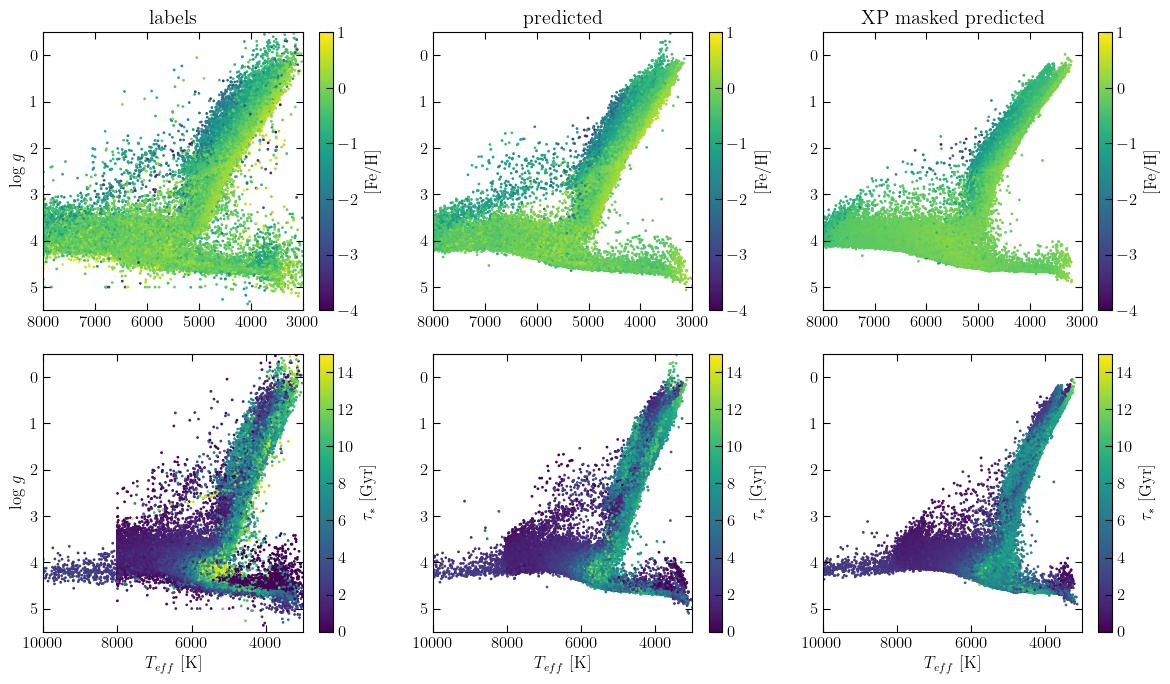

In [60]:
fig, axs = plt.subplots(2,3,figsize=(12,7))

sc = axs[0,0].scatter(target_set[:, 0],target_set[:, 1],c=target_set[:, 2],s=1,vmin=-4,vmax=1)
# axs[0,0].set_xlabel(r'$T_{eff}$ [K]')
axs[0,0].set_ylabel(r'log $g$')
plt.colorbar(sc, ax=axs[0,0],label='[Fe/H]')
axs[0,0].set_xlim(8000,3000)
axs[0,0].set_ylim(5.5,-0.5)
axs[0,0].set_title('labels')
mask = ~np.isnan(target_set[:, 0]) & ~np.isnan(target_set[:, 1]) & ~np.isnan(target_set[:, 2])
sc = axs[0,1].scatter(pred_teffs[mask],pred_loggs[mask],c=pred_fehs[mask],s=1,vmin=-4,vmax=1)
# axs[0,1].set_xlabel(r'$T_{eff}$ [K]')
# axs[0,1].set_ylabel(r'log $g$')
plt.colorbar(sc, ax=axs[0,1], label='[Fe/H]')
axs[0,1].set_xlim(8000,3000)
axs[0,1].set_ylim(5.5,-0.5)
axs[0,1].set_title('predicted')
sc = axs[0,2].scatter(m_pred_teffs[mask],m_pred_loggs[mask],c=m_pred_fehs[mask],s=1,vmin=-4,vmax=1)
# axs[0,2].set_xlabel(r'$T_{eff}$ [K]')
# axs[0,2].set_ylabel(r'log $g$')
plt.colorbar(sc, ax=axs[0,2],label='[Fe/H]')
axs[0,2].set_xlim(8000,3000)
axs[0,2].set_ylim(5.5,-0.5)
axs[0,2].set_title('XP masked predicted')
sc = axs[1,0].scatter(target_set[:, 0],target_set[:, 1],c=target_set[:, 4],s=1,vmin=0,vmax=15)
axs[1,0].set_xlabel(r'$T_{eff}$ [K]')
axs[1,0].set_ylabel(r'log $g$')
plt.colorbar(sc, ax=axs[1,0],label=r'$\tau_*$ [Gyr]')
axs[1,0].set_xlim(10000,3000)
axs[1,0].set_ylim(5.5,-0.5)
mask = ~np.isnan(target_set[:, 0]) & ~np.isnan(target_set[:, 1]) & ~np.isnan(target_set[:, 4])
sc = axs[1,1].scatter(pred_teffs[mask],pred_loggs[mask],c=pred_ages[mask],s=1,vmin=0,vmax=15)
axs[1,1].set_xlabel(r'$T_{eff}$ [K]')
# axs[1,1].set_ylabel(r'log $g$')
plt.colorbar(sc, ax=axs[1,1], label=r'$\tau_*$ [Gyr]')
axs[1,1].set_xlim(10000,3000)
axs[1,1].set_ylim(5.5,-0.5)
sc = axs[1,2].scatter(m_pred_teffs[mask],m_pred_loggs[mask],c=m_pred_ages[mask],s=1,vmin=0,vmax=15)
axs[1,2].set_xlabel(r'$T_{eff}$ [K]')
# axs[1,2].set_ylabel(r'log $g$')
plt.colorbar(sc, ax=axs[1,2],label=r'$\tau_*$ [Gyr]')
axs[1,2].set_xlim(10000,3000)
axs[1,2].set_ylim(5.5,-0.5);
plt.tight_layout()

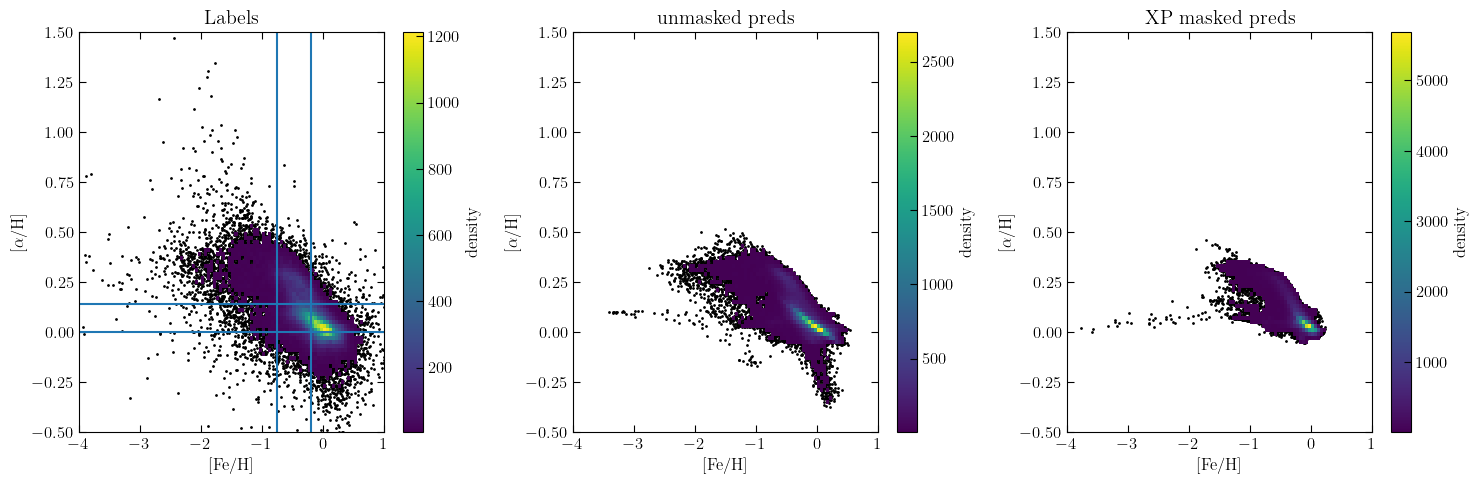

In [61]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
afe_mask = ~np.isnan(target_set[:, 3]) & ~np.isnan(target_set[:, 2])
axs[0].scatter(target_set[:, 2][afe_mask],target_set[:, 3][afe_mask],s=1,c='k')
h = axs[0].hist2d(target_set[:, 2][afe_mask],target_set[:, 3][afe_mask],bins=(100,100),cmin=5,range=[[-4,1],[-0.5,1.5]])
axs[0].set_xlabel(r'[Fe/H]')
axs[0].set_ylabel(r'[$\alpha$/H]')
axs[0].set_title('Labels')
axs[0].axvline(-.2)
axs[0].axvline(-.75)
axs[0].axhline(0)
axs[0].axhline(0.14)
plt.colorbar(h[-1], ax=axs[0],label=r'density')
axs[1].scatter(pred_fehs[afe_mask],pred_afes[afe_mask],s=1,c='k')
h = axs[1].hist2d(pred_fehs[afe_mask],pred_afes[afe_mask],bins=(100,100),cmin=5,range=[[-4,1],[-0.5,1.5]])
axs[1].set_xlabel(r'[Fe/H]')
axs[1].set_ylabel(r'[$\alpha$/H]')
plt.colorbar(h[-1], ax=axs[1], label=r'density')
axs[1].set_title('unmasked preds')
axs[2].scatter(m_pred_fehs[afe_mask],m_pred_afes[afe_mask],s=1,c='k')
h = axs[2].hist2d(m_pred_fehs[afe_mask],m_pred_afes[afe_mask],bins=(100,100),cmin=5,range=[[-4,1],[-0.5,1.5]])
axs[2].set_xlabel(r'[Fe/H]')
axs[2].set_ylabel(r'[$\alpha$/H]')
plt.colorbar(h[-1], ax=axs[2], label=r'density')
axs[2].set_title('XP masked preds')
plt.tight_layout()

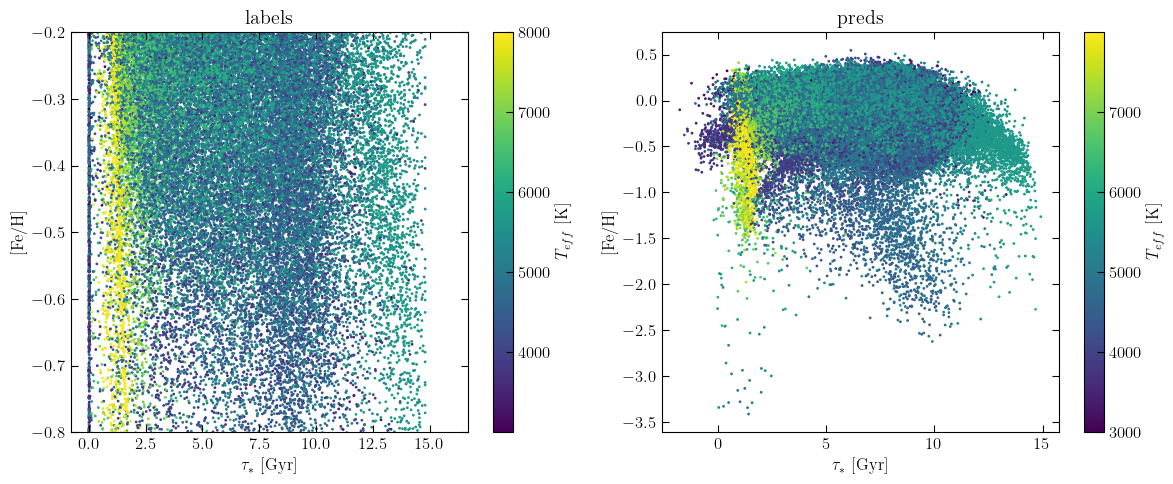

In [62]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
# mask = (target_set[:, 2] < -.2) & (target_set[:, 2] > -.75) & (target_set[:, 3] > 0) & (target_set[:, 3] < .14) & 
mask = ~np.isnan(target_set[:, 4]) & ~np.isnan(target_set[:, 0]) & ~np.isnan(target_set[:, 2])
sc = axs[0].scatter(target_set[:, 4][mask],target_set[:, 2][mask],c=target_set[:, 0][mask],s=1)#,vmin=3000,vmax=8000)
axs[0].set_xlabel(r'$\tau_{*}$ [Gyr]')
axs[0].set_ylabel(r'[Fe/H]')
axs[0].set_ylim(-0.8,-0.2)
axs[0].set_title('labels')
plt.colorbar(sc, ax=axs[0],label=r'$T_{eff}$ [K]')
mask = mask & (pred_teffs < 8000)
sc = axs[1].scatter(pred_ages[mask],pred_fehs[mask],c=pred_teffs[mask],s=1)#,vmin=3000,vmax=8000)
axs[1].set_xlabel(r'$\tau_{*}$ [Gyr]')
axs[1].set_ylabel(r'[Fe/H]')
# axs[1].set_ylim(-0.8,-0.2)
plt.colorbar(sc, ax=axs[1], label=r'$T_{eff}$ [K]')
axs[1].set_title('preds')
plt.tight_layout()


In [63]:
mask = (target_set[:, 0] < e_upper_teffs) & (target_set[:, 0] > e_lower_teffs) & ~np.isnan(target_set[:, 0])
mask2 = (target_set[:, 0] > e_upper_teffs) & (target_set[:, 0] < e_lower_teffs) & ~np.isnan(target_set[:, 0])

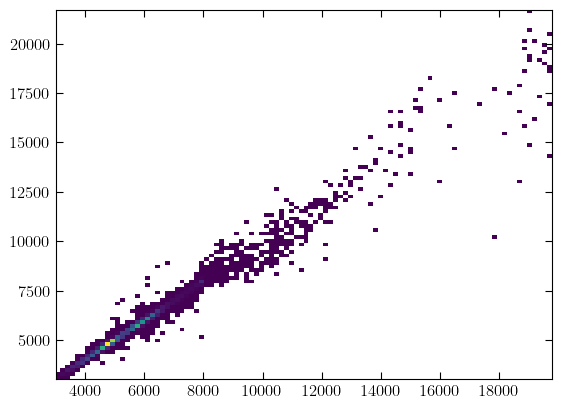

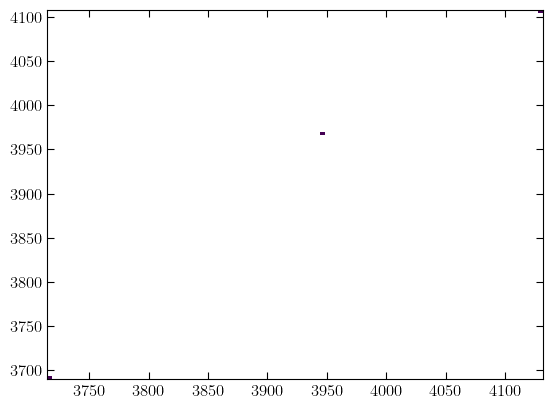

In [64]:
plt.hist2d(target_set[:, 0][mask],pred_teffs[mask],bins=(100,100),cmin=1);
plt.show()
plt.hist2d(target_set[:, 0][mask2],pred_teffs[mask2],bins=(100,100),cmin=1);

In [65]:
m3 = (pred_teffs > e_lower_teffs) & (pred_teffs < e_upper_teffs)
m4 = mask & m3

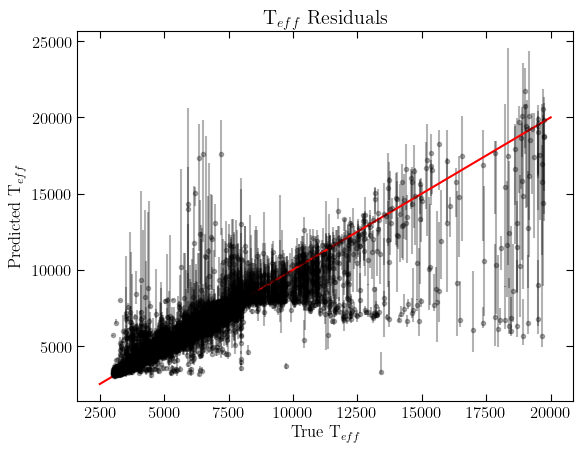

In [71]:
plt.errorbar(target_set[:, 0], pred_teffs, c='k' , yerr=[abs(pred_teffs-e_lower_teffs),abs(e_upper_teffs-pred_teffs)],fmt='.',alpha=0.3)
plt.title(r'T$_{eff}$ Residuals')
plt.xlabel(r'True T$_{eff}$')
plt.ylabel(r'Predicted T$_{eff}$');
plt.plot([2500,20000],[2500,20000],'r')

<ErrorbarContainer object of 3 artists>

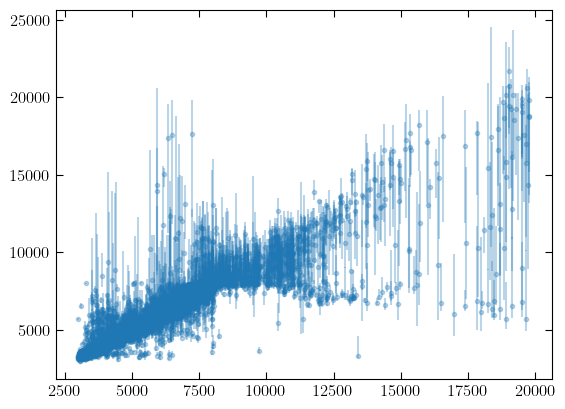

In [73]:
plt.errorbar(target_set[:, 0], pred_teffs, yerr=[abs(pred_teffs-e_lower_teffs),abs(e_upper_teffs-pred_teffs)],fmt='.',alpha=0.3)

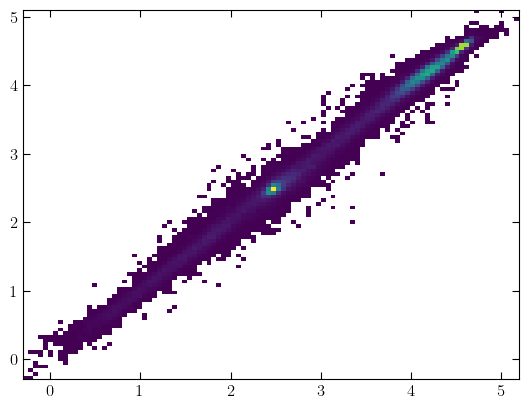

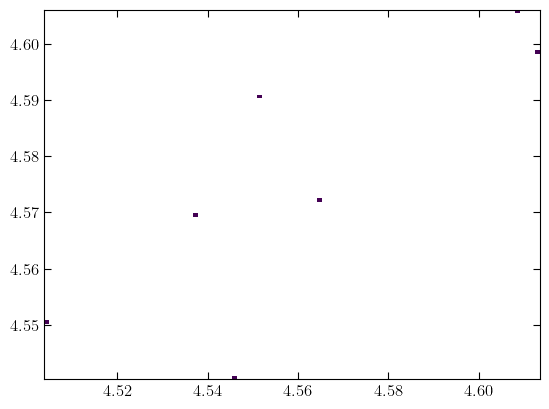

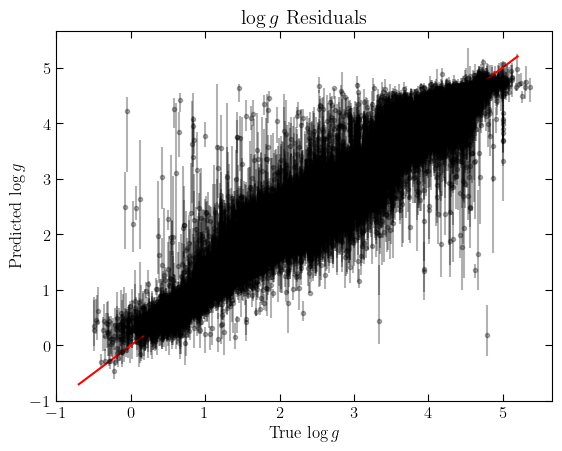

In [74]:
mask = (target_set[:, 1] < e_upper_loggs) & (target_set[:, 1] > e_lower_loggs) & ~np.isnan(target_set[:, 1])
mask2 = (target_set[:, 1] > e_upper_loggs) & (target_set[:, 1] < e_lower_loggs) & ~np.isnan(target_set[:, 1])
mask3 = (pred_loggs > e_lower_loggs) & (pred_loggs < e_upper_loggs) & (target_set[:, 1] < e_upper_loggs) & (target_set[:, 1] > e_lower_loggs) & ~np.isnan(target_set[:, 1])
plt.hist2d(target_set[:, 1][mask],pred_loggs[mask],bins=(100,100),cmin=1);
plt.show()
plt.hist2d(target_set[:, 1][mask2],pred_loggs[mask2],bins=(100,100),cmin=1);
plt.show()
# plt.scatter(target_set[:, 1], pred_loggs)
plt.errorbar(target_set[:, 1], pred_loggs, c='k', yerr=[abs(pred_loggs-e_lower_loggs),abs(e_upper_loggs-pred_loggs)],fmt='.',alpha=0.3)
plt.title(r'$\log{g}$ Residuals')
plt.xlabel(r'True $\log{g}$')
plt.ylabel(r'Predicted $\log{g}$');
plt.plot([-.7,5.2],[-.7,5.2],'r')

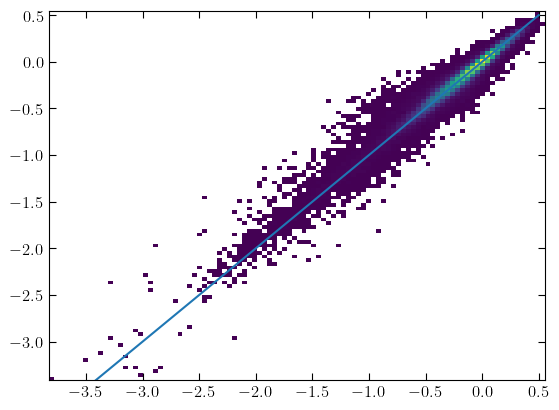

60721


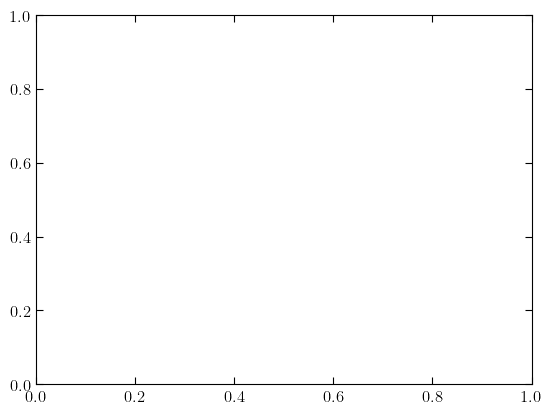

0


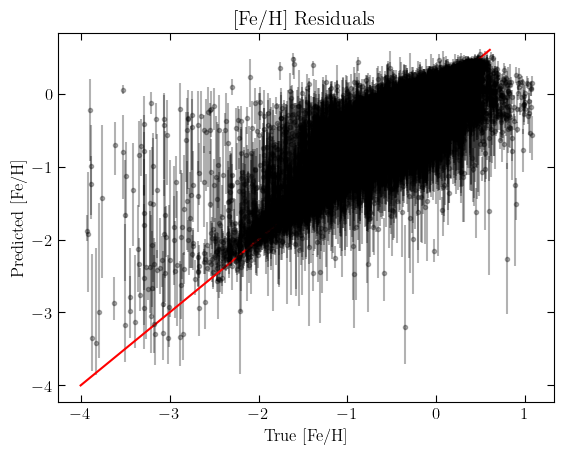

In [75]:
mask = (target_set[:, 2] < e_upper_fehs) & (target_set[:, 2] > e_lower_fehs) & ~np.isnan(target_set[:, 2])
mask2 = (target_set[:, 2] > e_upper_fehs) & (target_set[:, 2] < e_lower_fehs) & ~np.isnan(target_set[:, 2])
mask3 = (pred_fehs > e_lower_fehs) & (pred_fehs < e_upper_fehs) & (target_set[:, 2] < e_upper_fehs) & (target_set[:, 2] > e_lower_fehs) & ~np.isnan(target_set[:, 2])
plt.hist2d(target_set[:, 2][mask],pred_fehs[mask],bins=(100,100),cmin=1);
plt.plot([-4,.5],[-4,0.5])
plt.show()
print(sum(mask))
plt.hist2d(target_set[:, 2][mask2],pred_fehs[mask2],bins=(100,100),cmin=1);
plt.show()
print(sum(mask2))
plt.errorbar(target_set[:, 2], pred_fehs, c='k', yerr=[abs(pred_fehs-e_lower_fehs),abs(e_upper_fehs-pred_fehs)],fmt='.',alpha=0.3)
plt.title(r'[Fe/H] Residuals')
plt.xlabel(r'True [Fe/H]')
plt.ylabel(r'Predicted [Fe/H]');
plt.plot([-4,0.6],[-4,.6],'r')

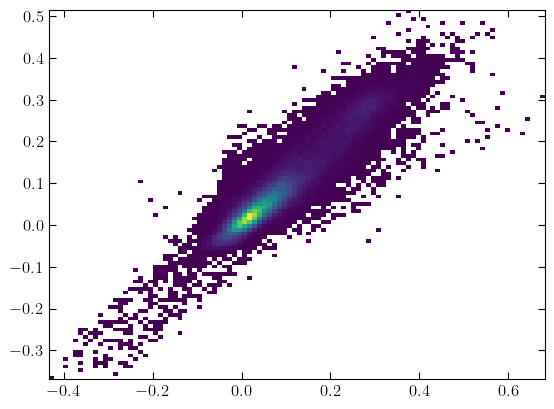

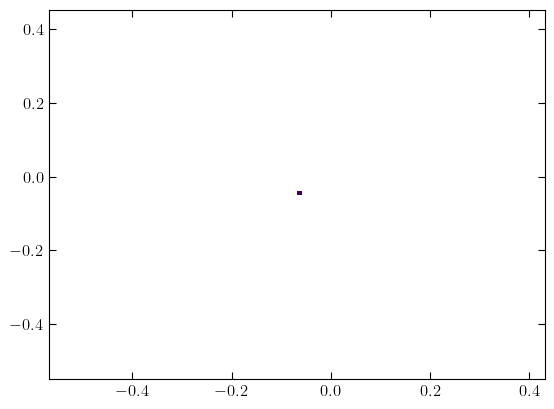

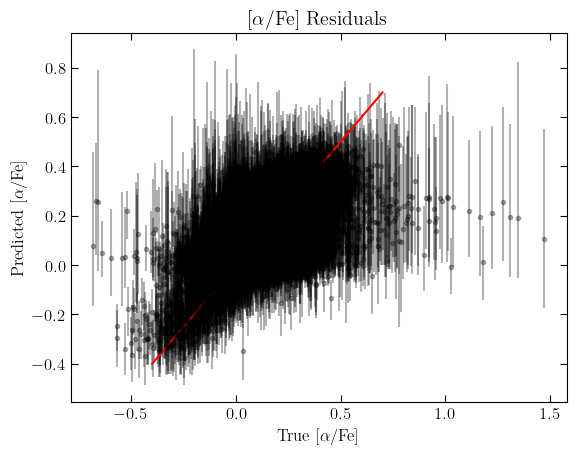

In [76]:
mask = (target_set[:, 3] < e_upper_afes) & (target_set[:, 3] > e_lower_afes) & ~np.isnan(target_set[:, 3])
mask2 = (target_set[:, 3] > e_upper_afes) & (target_set[:, 3] < e_lower_afes) & ~np.isnan(target_set[:, 3])
mask3 = (pred_afes > e_lower_afes) & (pred_afes < e_upper_afes) & (target_set[:, 3] < e_upper_afes) & (target_set[:, 3] > e_lower_afes) & ~np.isnan(target_set[:, 3])
plt.hist2d(target_set[:, 3][mask],pred_afes[mask],bins=(100,100),cmin=1);
plt.show()
plt.hist2d(target_set[:, 3][mask2],pred_afes[mask2],bins=(100,100),cmin=1);
plt.show()
plt.errorbar(target_set[:, 3], pred_afes, c='k', yerr=[abs(pred_afes-e_lower_afes),abs(e_upper_afes-pred_afes)],fmt='.',alpha=0.3)
plt.title(r'[$\alpha$/Fe] Residuals')
plt.xlabel(r'True [$\alpha$/Fe]')
plt.ylabel(r'Predicted [$\alpha$/Fe]');
plt.plot([-.4,0.7],[-.4,.7],'r')

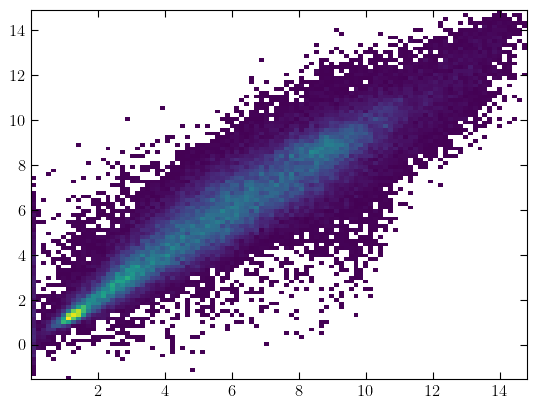

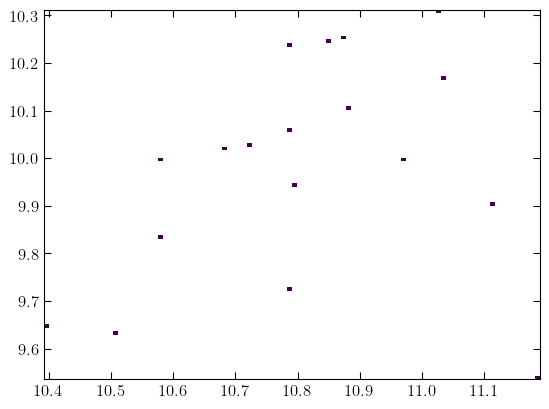

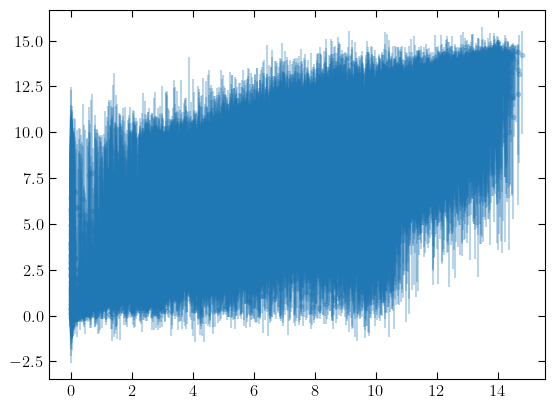

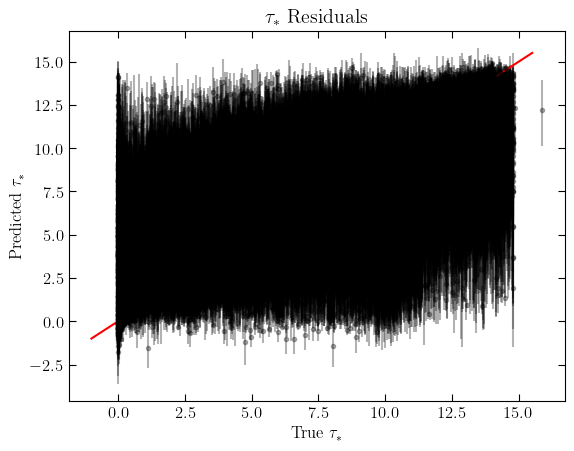

In [77]:
mask = (target_set[:, 4] < e_upper_ages) & (target_set[:, 4] > e_lower_ages) & ~np.isnan(target_set[:, 4])
mask2 = (target_set[:, 4] > e_upper_ages) & (target_set[:, 4] < e_lower_ages) & ~np.isnan(target_set[:, 4])
mask3 = (pred_ages > e_lower_ages) & (pred_ages < e_upper_ages) & (target_set[:, 4] < e_upper_ages) & (target_set[:, 4] > e_lower_ages) & ~np.isnan(target_set[:, 4])
plt.hist2d(target_set[:, 4][mask],pred_ages[mask],bins=(100,100),cmin=1);
plt.show()
plt.hist2d(target_set[:, 4][mask2],pred_ages[mask2],bins=(100,100),cmin=1);
plt.show()
plt.errorbar(target_set[:, 4][mask3], pred_ages[mask3], yerr=[pred_ages[mask3]-e_lower_ages[mask3],e_upper_ages[mask3]-pred_ages[mask3]],fmt='.',alpha=0.3)
plt.show()
plt.errorbar(target_set[:, 4], pred_ages, c='k', yerr=[abs(pred_ages-e_lower_ages),abs(e_upper_ages-pred_ages)],fmt='.',alpha=0.3)
plt.title(r'$\tau_*$ Residuals')
plt.xlabel(r'True $\tau_*$')
plt.ylabel(r'Predicted $\tau_*$');
plt.plot([-1,15.5],[-1,15.5],'r')

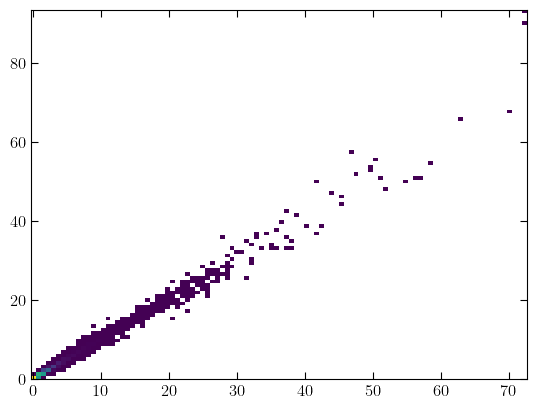

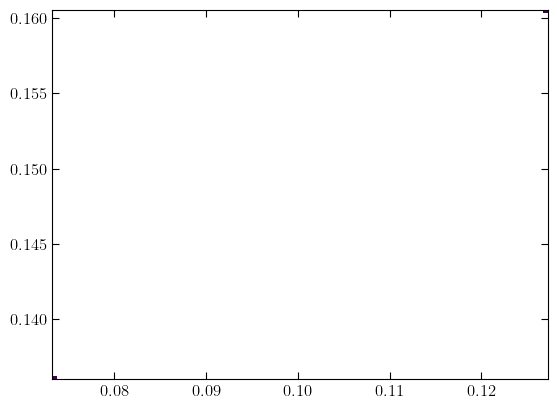

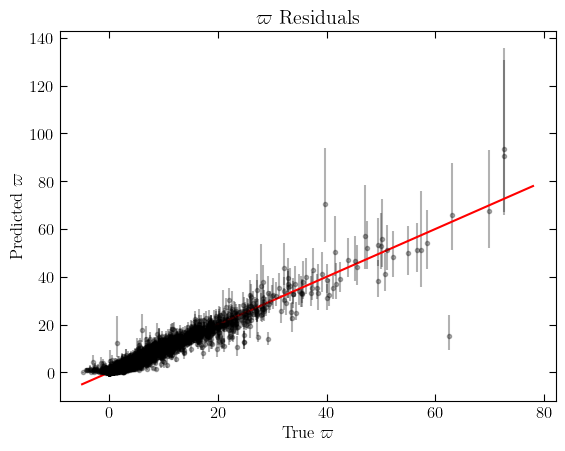

In [78]:
mask = (target_set[:, 5] < e_upper_parallaxs) & (target_set[:, 5] > e_lower_parallaxs) & ~np.isnan(target_set[:, 5])
mask2 = (target_set[:, 5] > e_upper_parallaxs) & (target_set[:, 5] < e_lower_parallaxs) & ~np.isnan(target_set[:, 5])
mask3 = (pred_parallax > e_lower_parallaxs) & (pred_parallax < e_upper_parallaxs) & (target_set[:, 5] < e_upper_parallaxs) & (target_set[:, 5] > e_lower_parallaxs) & ~np.isnan(target_set[:, 5])
plt.hist2d(target_set[:, 5][mask],pred_parallax[mask],bins=(100,100),cmin=1);
plt.show()
plt.hist2d(target_set[:, 5][mask2],pred_parallax[mask2],bins=(100,100),cmin=1);
plt.show()
plt.errorbar(target_set[:, 5], pred_parallax, c='k', yerr=[abs(pred_parallax-e_lower_parallaxs),abs(e_upper_parallaxs-pred_parallax)],fmt='.',alpha=0.3)
plt.title(r'$\varpi$ Residuals')
plt.xlabel(r'True $\varpi$')
plt.ylabel(r'Predicted $\varpi$');
plt.plot([-5,78],[-5,78],'r')